<a href="https://colab.research.google.com/github/jafetimbre/ms-school-stuff/blob/master/image-processing/coin_counter/coin_counter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2
import numpy as np
from urllib.request import urlopen
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [3]:
def show_figure(img, size=(10, 10)):
    plt.figure(figsize=size)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [4]:
req = urlopen("https://raw.githubusercontent.com/jafetimbre/ms-school-stuff/master/image-processing/coin_counter/res/new/1.png")
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
coins = cv2.imdecode(arr, -1)

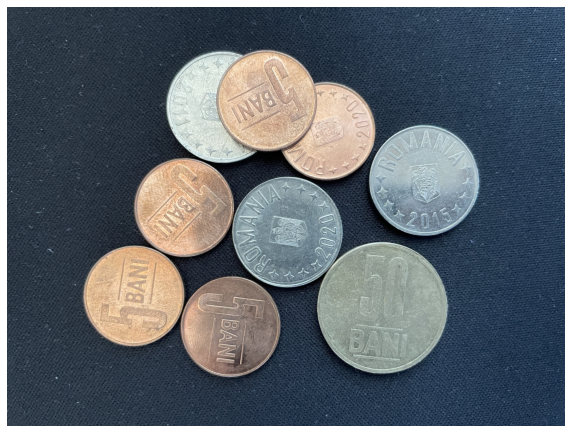

In [5]:
show_figure(coins)

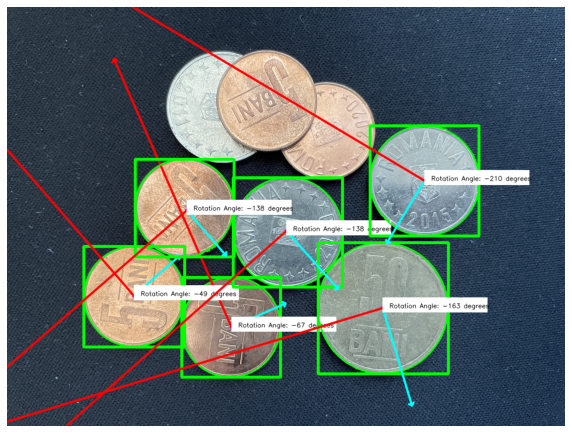

In [57]:
img = coins.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

contour, hierarchy = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

coins_detected = []

for cnt in contour:
    area = cv2.contourArea(cnt)
    if area > 100:
        approx_poly = cv2.approxPolyDP(cnt, .03 * cv2.arcLength(cnt, True), True)
        is_convex = cv2.isContourConvex(approx_poly)

        if is_convex:
            cv2.drawContours(image=img, contours=[cnt], contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
            x, y, w, h = cv2.boundingRect(approx_poly)
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 5)
            coins_detected.append((x, y, w, h))

            roi = coins[y:y+h, x:x+w]
            getOrientation(cnt, img)
            # show_figure(roi)
        else:
            x, y, w, h = cv2.boundingRect(approx_poly)
            # asd.append([ x, y, w, h])

show_figure(img)

TypeError: ignored

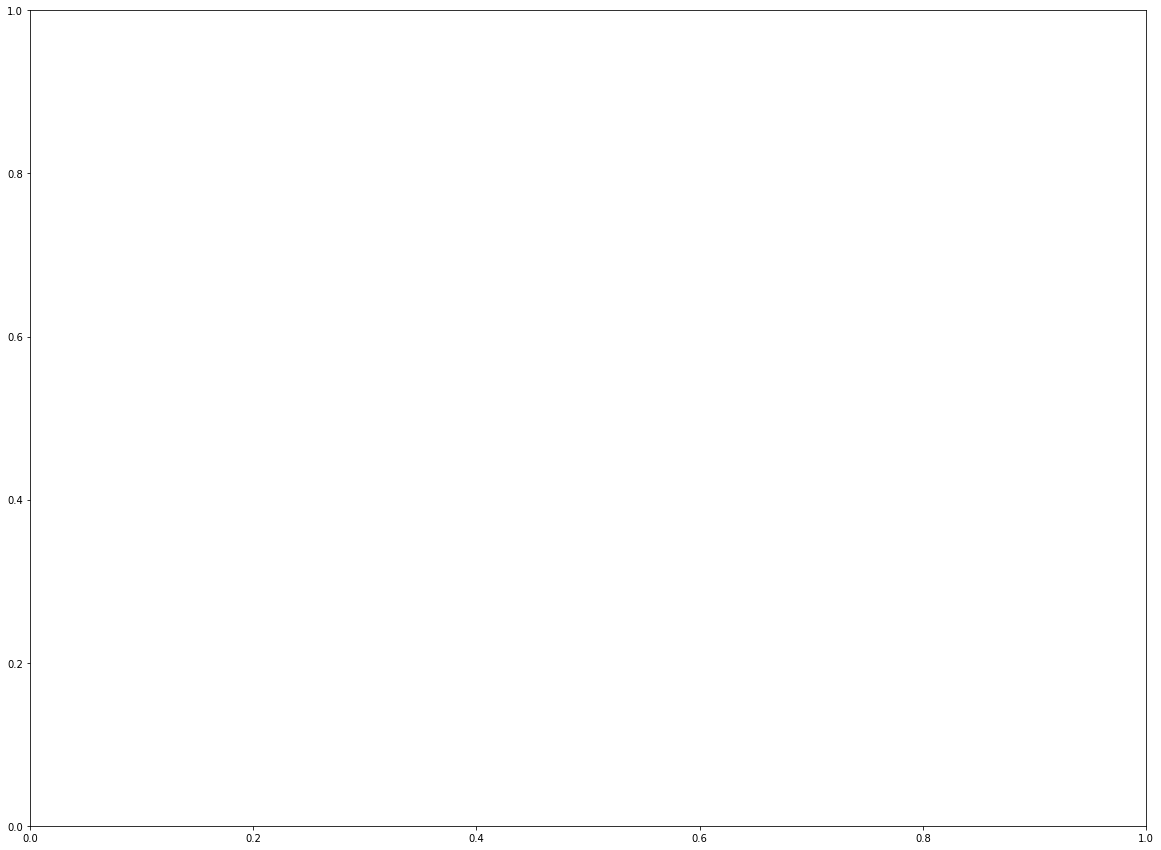

In [45]:
nr_coins = len(coins_detected)
fig, axs = plt.subplots(1, nr_coins, figsize=(20,15))

for i, roi in enumerate(coins_detected):
    axs[i].axis("off")
    coin = coins[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]
    axs[i].imshow(cv2.cvtColor(coin, cv2.COLOR_BGR2RGB))

In [52]:
import math

def drawAxis(img, p_, q_, color, scale):
  p = list(p_)
  q = list(q_)
 
  ## [visualization1]
  angle = math.atan2(p[1] - q[1], p[0] - q[0]) # angle in radians
  hypotenuse = math.sqrt((p[1] - q[1]) * (p[1] - q[1]) + (p[0] - q[0]) * (p[0] - q[0]))
 
  # Here we lengthen the arrow by a factor of scale
  q[0] = p[0] - scale * hypotenuse * math.cos(angle)
  q[1] = p[1] - scale * hypotenuse * math.sin(angle)
  cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv2.LINE_AA)
 
  # create the arrow hooks
  p[0] = q[0] + 9 * math.cos(angle + math.pi / 4)
  p[1] = q[1] + 9 * math.sin(angle + math.pi / 4)
  cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv2.LINE_AA)
 
  p[0] = q[0] + 9 * math.cos(angle - math.pi / 4)
  p[1] = q[1] + 9 * math.sin(angle - math.pi / 4)
  cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv2.LINE_AA)

In [54]:
def getOrientation(pts, img):
  ## [pca]
  # Construct a buffer used by the pca analysis
  sz = len(pts)
  data_pts = np.empty((sz, 2), dtype=np.float64)
  for i in range(data_pts.shape[0]):
    data_pts[i,0] = pts[i,0,0]
    data_pts[i,1] = pts[i,0,1]
 
  # Perform PCA analysis
  mean = np.empty((0))
  mean, eigenvectors, eigenvalues = cv2.PCACompute2(data_pts, mean)
 
  # Store the center of the object
  cntr = (int(mean[0,0]), int(mean[0,1]))
  ## [pca]
 
  ## [visualization]
  # Draw the principal components
  cv2.circle(img, cntr, 3, (255, 0, 255), 2)
  p1 = (cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 0.02 * eigenvectors[0,1] * eigenvalues[0,0])
  p2 = (cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
  drawAxis(img, cntr, p1, (255, 255, 0), 1)
  drawAxis(img, cntr, p2, (0, 0, 255), 5)
 
  angle = math.atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radians
  ## [visualization]
 
  # Label with the rotation angle
  label = "  Rotation Angle: " + str(-int(np.rad2deg(angle)) - 90) + " degrees"
  textbox = cv2.rectangle(img, (cntr[0], cntr[1]-25), (cntr[0] + 250, cntr[1] + 10), (255,255,255), -1)
  cv2.putText(img, label, (cntr[0], cntr[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
 
  return angle

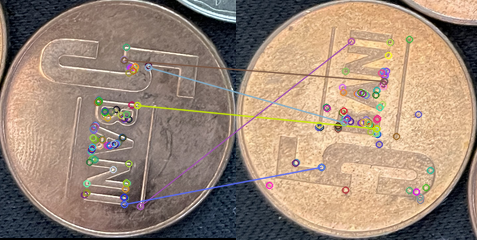

In [31]:
MAX_FEATURES = 100
GOOD_MATCH_PERCENT = .2

orb = cv2.ORB_create(MAX_FEATURES)

roi = coins_detected[0]
test_img_a = coins[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]
gray1 = cv2.cvtColor(test_img_a, cv2.COLOR_BGR2GRAY)
keypoints1, descriptors1 = orb.detectAndCompute(gray1, None)

roi = coins_detected[1]
test_img_b = coins[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]
gray2 = cv2.cvtColor(test_img_b, cv2.COLOR_BGR2GRAY)
keypoints2, descriptors2 = orb.detectAndCompute(gray2, None)

matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches = matcher.match(descriptors1, descriptors2, None)

# matches.sort(key=lambda x: x.distance, reverse=False)
numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
matches = matches[:5]

imMatches = cv2.drawMatches(test_img_a, keypoints1, test_img_b, keypoints2, matches, None)
cv2_imshow(imMatches)


# # kp = sift.detect(gray, None)
# # find the keypoints with ORB
# kp = orb.detect(gray, None)

# # compute the descriptors with ORB
# kp, des = orb.compute(gray, kp)

# # draw only keypoints location,not size and orientation
# img2 = cv2.drawKeypoints(gray,kp,color=(0,255,0), flags=0)



In [ ]:
img = coins.copy()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
mask = cv2.threshold(gray, 0, 200, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

masked = cv2.bitwise_and(img, img, mask=mask)

show_figure(masked)

In [ ]:
padding = 10
roi = asd[0]
roi = [roi[0]-padding, roi[1]-padding, roi[2]+padding*2, roi[3]+padding*2]

t_im = coins[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]
show_figure(t_im)

In [ ]:
img = t_im.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=)
show_figure(opening)

In [ ]:
output = t_im.copy()
gray = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1.2, 100)

In [ ]:
if circles is not None:
	# convert the (x, y) coordinates and radius of the circles to integers
	circles = np.round(circles[0, :]).astype("int")
	# loop over the (x, y) coordinates and radius of the circles
	for (x, y, r) in circles:
		# draw the circle in the output image, then draw a rectangle
		# corresponding to the center of the circle
		cv2.circle(gray, (x, y), r, (0, 255, 0), 4)
		# cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
	# show the output image
show_figure(gray)